In [2]:
# Initial imports
import time
start = time.time()

import os
import sys
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from sklearn import metrics

import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier 
import pickle


end = time.time()
print(f'Imports took {end-start} seconds')


Imports took 36.45792031288147 seconds


In [3]:
major_files_path = 'Audio_Files/Major/'
minor_files_path = 'Audio_files/Minor/'
major_sample_1 = 'Major_2.wav'

IPython.display.Audio(f'{major_files_path}{major_sample_1}', rate=44100)

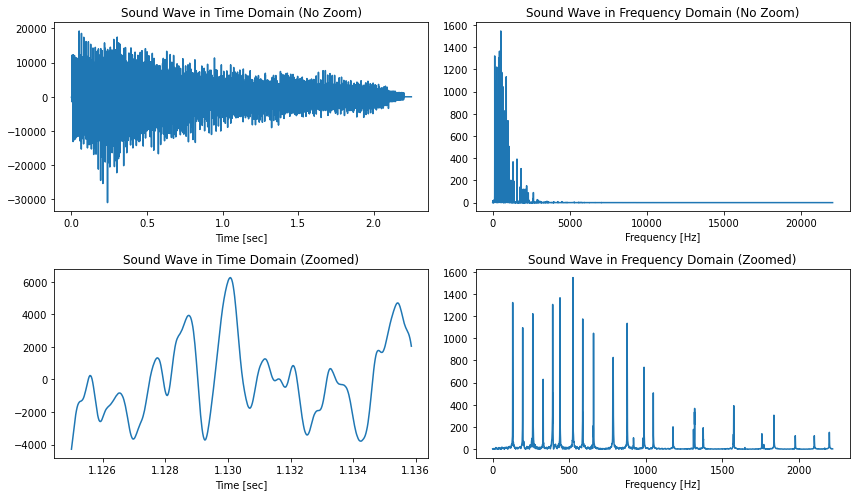

In [4]:
# Code referenced from another notebook by Ahmet Celik
fs, signal = wavfile.read(f'{major_files_path}{major_sample_1}') # get a frequency sample and signal from a wavfile
# print(fs)
# print(signal)
N = len(signal)
time = np.linspace(0., N/fs, N)
# print(time)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2] # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # postive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (No Zoom)")
axes[0,0].set(xlabel="Time [sec]")
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel="Frequency [Hz]")

axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel="Time [sec]")
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel="Frequency [Hz]")
fig.tight_layout()
plt.show()

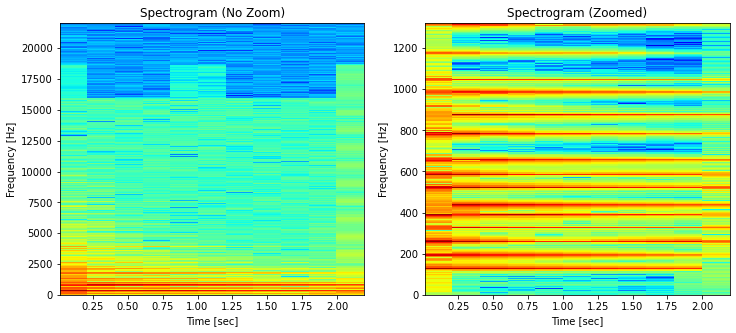

In [4]:
# applying spectrogram
f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft=50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap='jet', shading='auto')
axes[0].set_title('Spectrogram (No Zoom)')
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap='jet', shading='auto')
axes[1].set_title('Spectrogram (Zoomed)')
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

In [5]:
def generateNoZoomSpectrogram(f, t, Sxx):
    fig_zoomed, axes_zoomed = plt.subplots(figsize=(6, 5))
    axes_zoomed.pcolormesh(t, f, np.log(Sxx), cmap='jet', shading='auto')
    axes_zoomed.set_title('Spectrogram (No Zoom)')
    axes_zoomed.set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
    plt.show()

    canvas_zoomed = FigureCanvasAgg(fig_zoomed)
    canvas_zoomed.draw()
    rgba = np.asarray(canvas_zoomed.buffer_rgba())
    # ... and pass it to PIL.
    im = Image.fromarray(rgba)
    s_zoomed, (width_zoomed, height_zoomed) = canvas.print_to_buffer()
    print(width_zoomed)
    print(height_zoomed)

    # Option 2a: Convert to a NumPy array.
    img_zoomed = np.frombuffer(s_zoomed, np.uint8).reshape((height_zoomed, width_zoomed, 4))
    print(img_zoomed.shape)
    
    return img_zoomed

def generateZoomedSpectrogram(f, t, Sxx):
    fig_nozoom, axes_nozoom = plt.subplots(figsize=(6, 5))
    axes_nozoom.pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap='jet', shading='auto')
    axes_nozoom.set_title('Spectrogram (Zoomed)')
    axes_nozoom.set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
    plt.show()

    canvas_nozoom = FigureCanvas(fig_nozoom)
    canvas_nozoom.draw()
    s_nozoom, (width_nozoom, height_nozoom) = canvas.print_to_buffer()
    print(width_nozoom)
    print(height_nozoom)

    # Option 2a: Convert to a NumPy array.
    img_nozoom = np.frombuffer(s_nozoom, np.uint8).reshape((height_zoomed, width_zoomed, 4))
    print(img_nozoom.shape)
    
    return img_nozoom

Harmonics: [ 131.  196.  257.  262.  330.  392.  440.  520.  525.  588.  659.  788.
  879.  920.  981.  989. 1050. 1179. 1312. 1320. 1376. 1576. 1760. 1838.
 1978. 2102. 2200. 2308. 2640.]


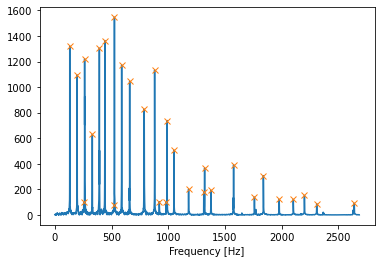

In [6]:
# h: height treshold. Defined as 5% of the max value
h = signal_f_onesided.max()*.05
peaks, _ = find_peaks(signal_f_onesided, distance=10, height=h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz
peaks = peaks[peaks > freq_50_index] # filtering peaks less than 50 Hz
harmonics = y_freq[peaks]
print(f'Harmonics: {np.round(harmonics)}')

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], 'x')
plt.xlabel('Frequency [Hz]')
plt.show()

In [7]:
# Method to read sound file, apply Fourier Transformation, find and return peak frequencies
# Input: 
# --- path = path of sound file
# --- print_peaks = true to plot peaks
# Output: Frequency peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*.05
    peaks, _ = find_peaks(X_F_onesided, distance=10, height=h)
    peaks = peaks[peaks > freq_50_index]
    harmonics = np.round(freqs[peaks], 2)
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], 'x')
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

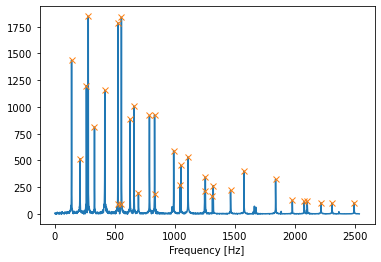

Harmonics: [ 139.  209.  262.  278.  330.  415.  525.  530.  550.  554.  626.  659.
  696.  787.  830.  834.  989. 1043. 1050. 1109. 1247. 1253. 1313. 1319.
 1463. 1575. 1838. 1978. 2077. 2102. 2217. 2309. 2493.]


In [8]:
# Another example to check if method is working correctly
minor_sample_1 = 'Minor_10.wav'
harmonics_2 = find_harmonics(f'{minor_files_path}{minor_sample_1}', print_peaks=True)
print(f'Harmonics: {np.round(harmonics_2)}')

***Importing Dataset***

In [9]:
path = 'Audio_Files'
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns
# Stopping here 4/19

# Begin from 4/20
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        ind_data = [foldername, filename]
        ind_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        ind_data.extend(freq_peaks)
        
        data.append(ind_data)
        
print(data)

[['Major', 'Major_0.wav', 130.67, 1838.22, 21, 130.67, 165.33, 196.0, 262.22, 330.22, 392.0, 495.56, 524.89, 588.44, 659.11, 787.11, 826.22, 989.33, 1049.78, 1158.22, 1178.67, 1312.44, 1319.11, 1376.0, 1575.56, 1838.22], ['Major', 'Major_1.wav', 131.11, 993.33, 16, 131.11, 165.33, 174.67, 196.44, 261.78, 266.67, 331.11, 340.0, 392.44, 496.0, 524.0, 589.78, 655.56, 661.33, 919.11, 993.33], ['Major', 'Major_10.wav', 130.91, 1408.64, 20, 130.91, 185.0, 234.09, 262.27, 329.55, 370.45, 393.18, 468.18, 555.45, 659.09, 702.73, 741.36, 788.18, 927.27, 937.73, 989.55, 1113.18, 1172.73, 1319.09, 1408.64], ['Major', 'Major_100.wav', 155.45, 2449.09, 27, 155.45, 195.91, 278.18, 311.36, 349.55, 392.27, 466.82, 556.36, 588.18, 622.73, 699.09, 778.64, 784.55, 835.0, 935.0, 1050.0, 1091.36, 1112.73, 1178.64, 1248.18, 1375.91, 1391.82, 1399.09, 1573.64, 1670.45, 1949.09, 2449.09], ['Major', 'Major_101.wav', 155.91, 1093.64, 20, 155.91, 175.45, 196.82, 273.18, 278.18, 283.18, 311.36, 316.36, 341.82, 350

In [10]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Data Exploration***

In [11]:
# The target we are going to evaluate
df["Chord Type"].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

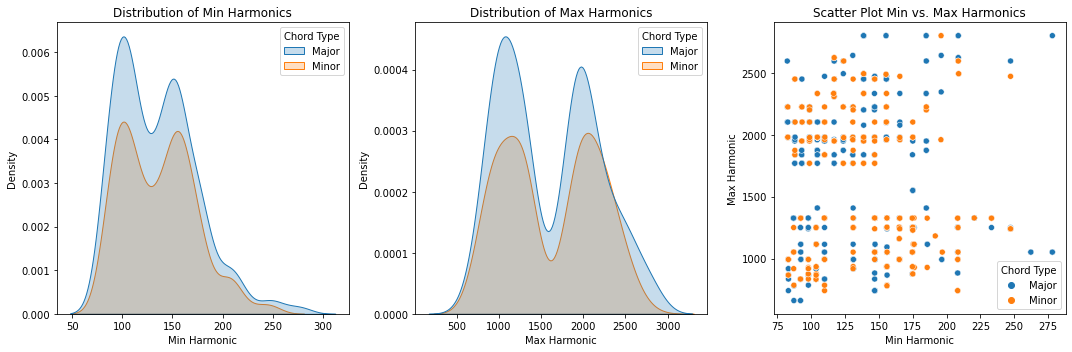

In [12]:
# Min and Max Harmonics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", shade=True)
sns.scatterplot(ax=axes[2], data=df, x="Min Harmonic", y="Max Harmonic",hue="Chord Type")
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
axes[2].set_title("Scatter Plot Min vs. Max Harmonics")
fig.tight_layout()
plt.show()

In [13]:
# Number of Harmonics
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [14]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

In [15]:
# Feature Engineering on Harmonics
df_original = df.copy() # Keeping original of df, I may need later

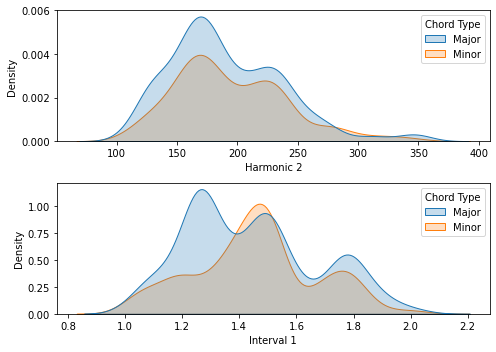

In [16]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

In [17]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,1.049688,1.197417,1.061102,1.103298,1.017656,1.113492,1.005082,1.043128,1.145029,1.166709
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,1.125534,1.111533,1.008802,1.389790,1.080752,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,1.054971,1.063154,1.176470,1.011280,1.055261,1.124936,1.053495,1.124803,1.067888,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,1.113791,1.007590,1.064304,1.119760,1.122995,1.039390,1.019581,1.059233,1.059000,1.102333
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,1.188654,1.191808,1.060464,1.057780,1.251999,1.069225,1.120785,1.124279,1.038861,NaN


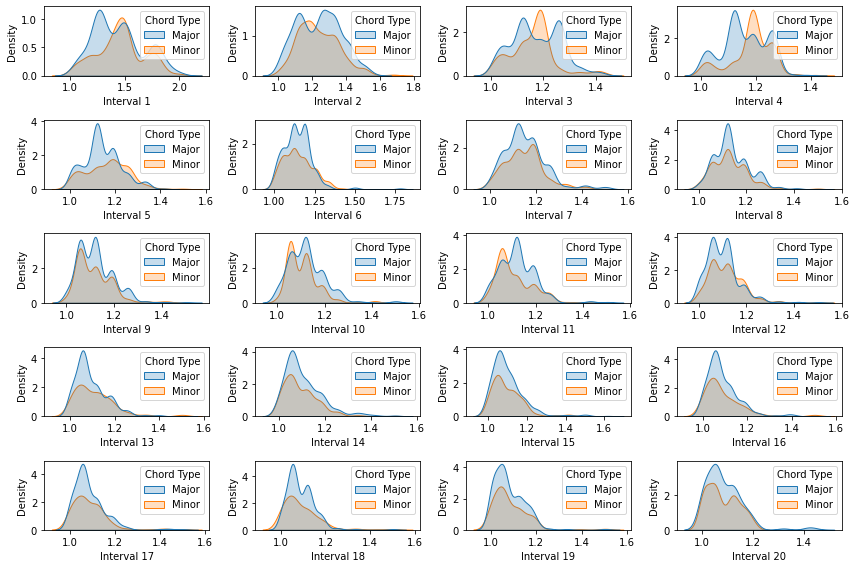

In [18]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

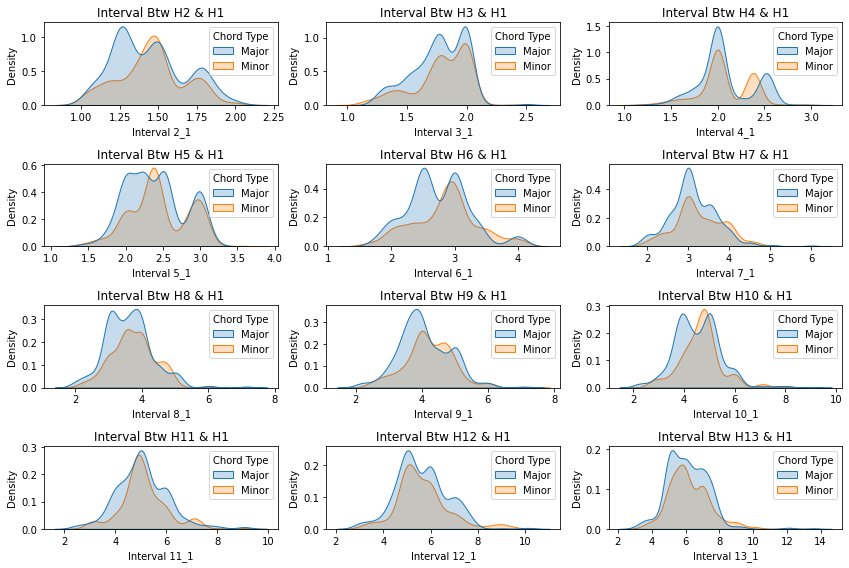

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

***Model Evaluation***

In [20]:
# Data Preprocessing 

# Using 1 and 0 to represent Major and Minor
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4"]
columns.extend(["Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.40, random_state=0)
print(df["Chord Type"])

train_X.head()

0      1
1      1
2      1
3      1
4      1
      ..
854    0
855    0
856    0
857    0
858    0
Name: Chord Type, Length: 859, dtype: int64


,Interval 1,Interval 2,Interval 3,Interval 4,Interval 4_1,Interval 5_1,Interval 6_1
585,1.793936,1.119604,1.188029,1.262596,2.386153,3.012746,3.579278
403,1.266029,1.416978,1.119604,1.121779,2.008497,2.253090,2.527810
532,1.788230,1.063333,1.051867,1.029531,2.000108,2.059174,2.389184
104,1.252365,1.332132,1.198879,1.121500,2.000107,2.243121,2.514187
303,1.389736,1.019817,1.093394,1.024923,1.549642,1.588264,2.000040


In [66]:
# Model Selection among Logistic, KNeighbors Classifier, SVM, 
# Gaussian NB, Decision Tree, Random Forest
lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
svc = SVC(C=10, kernel='rbf', gamma=0.0005, random_state=1)
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state=2)
rfc = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state=0)
xgb = XGBClassifier(n_estimators = 29,random_state=2,eval_metric='mlogloss',use_label_encoder=False)
ada = AdaBoostClassifier(n_estimators = 29,random_state=2)

score_lr = cross_val_score(lr, train_X, train_y, cv=10).mean()
score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_svc = cross_val_score(svc, train_X, train_y, cv=10).mean()
score_gnb = cross_val_score(gnb, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()
score_xgb = cross_val_score(xgb, train_X, train_y, cv=10).mean()
score_ada = cross_val_score(ada, train_X, train_y, cv=10).mean()

In [67]:
print("Cross Val Score for Logistic Regression: {:.2f}".format(score_lr))
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for SVC: {:.2f}".format(score_svc))
print("Cross Val Score for Gaussian NB: {:.2f}".format(score_gnb))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))
print("Cross Val Score for XGBoosting Classifier: {:.2f}".format(score_xgb))
print("Cross Val Score for AdaBoosting Classifier: {:.2f}".format(score_ada))

Cross Val Score for Logistic Regression: 0.58
Cross Val Score for KNeighbors Classifier: 0.83
Cross Val Score for SVC: 0.57
Cross Val Score for Gaussian NB: 0.68
Cross Val Score for Decision Tree Classifier: 0.90
Cross Val Score for Random Forest Classifier: 0.91
Cross Val Score for XGBoosting Classifier: 0.91
Cross Val Score for AdaBoosting Classifier: 0.89


In [38]:
# Model Training and Prediction
# defining RandomForest classifier
classifier = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state=0)

classifier.fit(train_X, train_y) # training classifier
pred_y = classifier.predict(val_X) # making prediction on validation
cm = confusion_matrix(val_y, pred_y)
acc = accuracy_score(val_y, pred_y)

print("Confusion Matrix:")
print(cm)
print("Accuracy Score: {:.2f}".format(acc))

y_RandomForest_proba = classifier.predict_proba(val_X)
# Computing fpr and tpr to get AUC
fpr_RandomForest, tpr_RandomForest, thresholds_RandomForest = metrics.roc_curve(val_y, y_RandomForest_proba[:,1], pos_label=1)

# print(fpr_RandomForest)
# print("\n\n\n")
# print(tpr_RandomForest)

# AUC:
RandomForest_AUC = metrics.auc(fpr_RandomForest, tpr_RandomForest)
print("The AUC of RandomForest is:", RandomForest_AUC)

Confusion Matrix:
[[122  11]
 [ 15 196]]
Accuracy Score: 0.92
The AUC of RandomForest is: 0.9748957702312653


In [39]:
# defining knn model
my_knn = KNeighborsClassifier()

my_knn.fit(train_X, train_y) # training classifier
knn_pred_y = my_knn.predict(val_X) # making prediction on validation

knn_cm = confusion_matrix(val_y, knn_pred_y)
knn_acc = accuracy_score(val_y, knn_pred_y)

print("Confusion Matrix:")
print(knn_cm)
print("Accuracy Score: {:.2f}".format(knn_acc))

y_knn_proba = my_knn.predict_proba(val_X)
# Computing fpr and tpr to get AUC
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(val_y, y_knn_proba[:,1], pos_label=1)

# AUC:
knn_AUC = metrics.auc(fpr_knn, tpr_knn)
print("The AUC of KNN is:", knn_AUC)

Confusion Matrix:
[[ 99  34]
 [ 28 183]]
Accuracy Score: 0.82
The AUC of KNN is: 0.8844207675587072


In [42]:
# defining knn model
my_decisiontree = DecisionTreeClassifier(random_state=2)

my_decisiontree.fit(train_X, train_y) # training classifier
decisiontree_pred_y = my_decisiontree.predict(val_X) # making prediction on validation

decisiontree_cm = confusion_matrix(val_y, decisiontree_pred_y)
decisiontree_acc = accuracy_score(val_y, decisiontree_pred_y)

print("Confusion Matrix:")
print(decisiontree_cm)
print("Accuracy Score: {:.2f}".format(decisiontree_acc))

y_decisiontree_proba = my_decisiontree.predict_proba(val_X)
# Computing fpr and tpr to get AUC
fpr_decisiontree, tpr_decisiontree, thresholds_decisiontree = metrics.roc_curve(val_y, y_decisiontree_proba[:,1], pos_label=1)

# AUC:
decisiontree_AUC = metrics.auc(fpr_decisiontree, tpr_decisiontree)
print("The AUC of KNN is:", decisiontree_AUC)

Confusion Matrix:
[[124   9]
 [ 22 189]]
Accuracy Score: 0.91
The AUC of KNN is: 0.915850051669458


In [68]:
# Model Training and Prediction
# defining XGBboost classifier
my_xgboost = XGBClassifier(n_estimators = 29,random_state=2,eval_metric='mlogloss',use_label_encoder=False)

my_xgboost.fit(train_X, train_y) # training classifier
xgboost_pred_y = my_xgboost.predict(val_X) # making prediction on validation
xgboost_cm = confusion_matrix(val_y, xgboost_pred_y)
xgboost_acc = accuracy_score(val_y, xgboost_pred_y)

print("Confusion Matrix:")
print(xgboost_cm)
print("Accuracy Score: {:.2f}".format(xgboost_acc))

y_xgboost_proba = my_xgboost.predict_proba(val_X)
# Computing fpr and tpr to get AUC
fpr_xgboost, tpr_xgboost, thresholds_xgboost = metrics.roc_curve(val_y, y_xgboost_proba[:,1], pos_label=1)

# AUC:
xgboost_AUC = metrics.auc(fpr_xgboost, tpr_xgboost)
print("The AUC of XGBoost is:", xgboost_AUC)

Confusion Matrix:
[[120  13]
 [ 18 193]]
Accuracy Score: 0.91
The AUC of XGBoost is: 0.9676620461105369


In [69]:
# Model Training and Prediction
# defining Adaboost classifier
my_AdaBoost = AdaBoostClassifier(n_estimators = 29,random_state=2)

my_AdaBoost.fit(train_X, train_y) # training classifier
AdaBoost_pred_y = my_AdaBoost.predict(val_X) # making prediction on validation
AdaBoost_cm = confusion_matrix(val_y, AdaBoost_pred_y)
AdaBoost_acc = accuracy_score(val_y, AdaBoost_pred_y)

print("Confusion Matrix:")
print(AdaBoost_cm)
print("Accuracy Score: {:.2f}".format(AdaBoost_acc))

y_AdaBoost_proba = my_AdaBoost.predict_proba(val_X)
# Computing fpr and tpr to get AUC
fpr_AdaBoost, tpr_AdaBoost, thresholds_AdaBoost = metrics.roc_curve(val_y, y_AdaBoost_proba[:,1], pos_label=1)

# AUC:
AdaBoost_AUC = metrics.auc(fpr_AdaBoost, tpr_AdaBoost)
print("The AUC of AdaBoost is:", AdaBoost_AUC)

Confusion Matrix:
[[105  28]
 [ 22 189]]
Accuracy Score: 0.85
The AUC of AdaBoost is: 0.9082956205680077


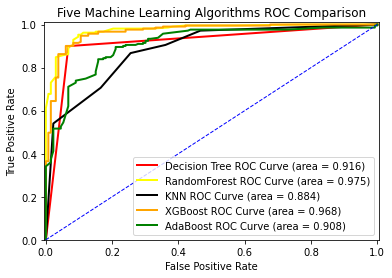

In [71]:
# The following line will tell Jupyter Notebook to keep the figures inside the explorer page 
%matplotlib inline

plt.figure()

# Decision Tree Roc Curve:
plt.plot(fpr_decisiontree, tpr_decisiontree, color='red', lw=2, 
         label='Decision Tree ROC Curve (area = %0.3f)' % decisiontree_AUC)

# RandomForest Roc Curve:
plt.plot(fpr_RandomForest, tpr_RandomForest, color='yellow', lw=2, 
         label='RandomForest ROC Curve (area = %0.3f)' % RandomForest_AUC)

# KNN Roc Curve:
plt.plot(fpr_knn, tpr_knn, color='black', lw=2, 
         label='KNN ROC Curve (area = %0.3f)' % knn_AUC)

# XGBoost Roc Curve:
plt.plot(fpr_xgboost, tpr_xgboost, color='orange', lw=2, 
         label='XGBoost ROC Curve (area = %0.3f)' % xgboost_AUC)

# Adaboost Roc Curve:
plt.plot(fpr_AdaBoost, tpr_AdaBoost, color='green', lw=2, 
         label='AdaBoost ROC Curve (area = %0.3f)' % AdaBoost_AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Five Machine Learning Algorithms ROC Comparison')
plt.legend(loc="lower right")

plt.show()

# Implement CNN

Audio_Files/Major/Major_0.wav


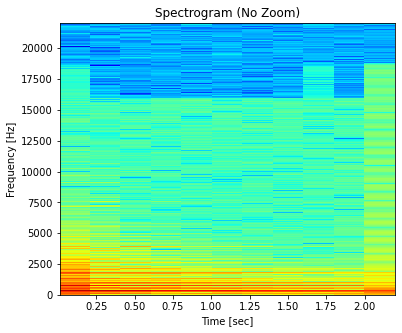

864
360
(360, 864, 4)
Audio_Files/Major/Major_1.wav


<ipython-input-81-6255c3a4cce3>:3: RuntimeWarning: divide by zero encountered in log
  axes_zoomed.pcolormesh(t, f, np.log(Sxx), cmap='jet', shading='auto')


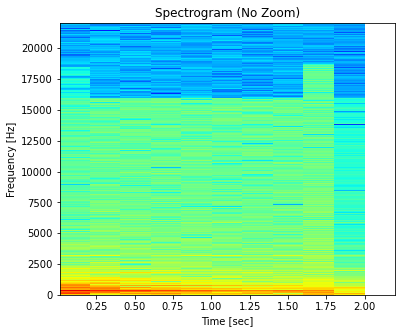

864
360
(360, 864, 4)
Audio_Files/Major/Major_2.wav


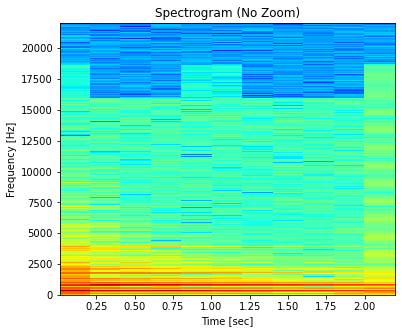

864
360
(360, 864, 4)
Audio_Files/Major/Major_3.wav


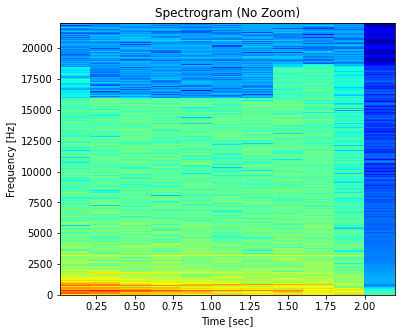

864
360
(360, 864, 4)
Audio_Files/Major/Major_4.wav


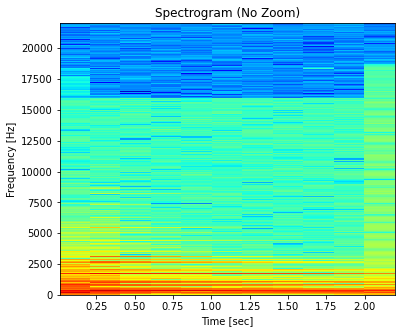

864
360
(360, 864, 4)
Audio_Files/Major/Major_5.wav


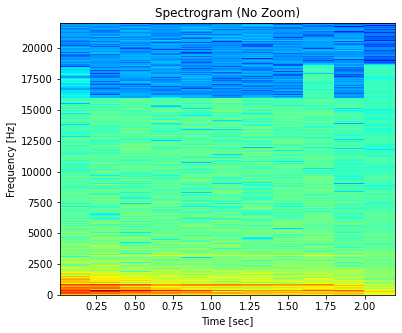

864
360
(360, 864, 4)
Audio_Files/Major/Major_6.wav


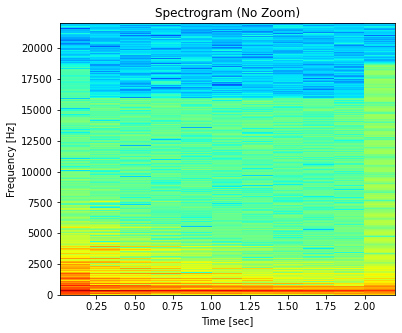

864
360
(360, 864, 4)
Audio_Files/Major/Major_7.wav


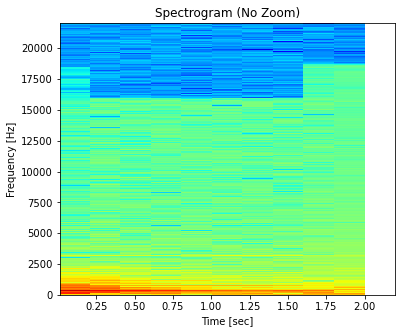

864
360
(360, 864, 4)
Audio_Files/Major/Major_8.wav


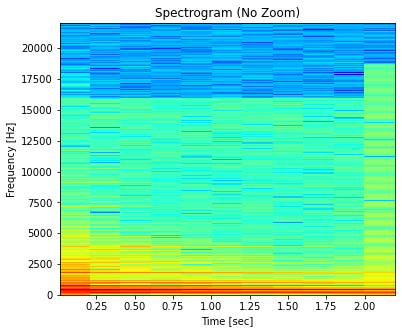

864
360
(360, 864, 4)
Audio_Files/Major/Major_9.wav


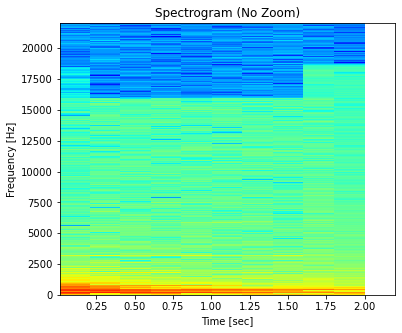

864
360
(360, 864, 4)
Audio_Files/Major/Major_10.wav


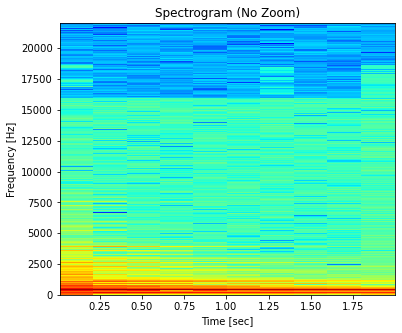

864
360
(360, 864, 4)
Audio_Files/Major/Major_11.wav


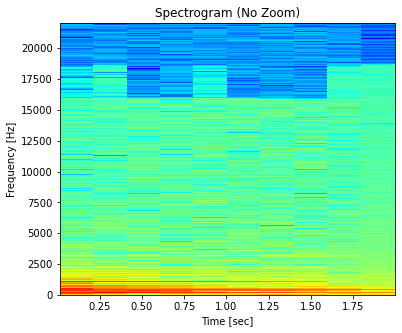

864
360
(360, 864, 4)
Audio_Files/Major/Major_12.wav


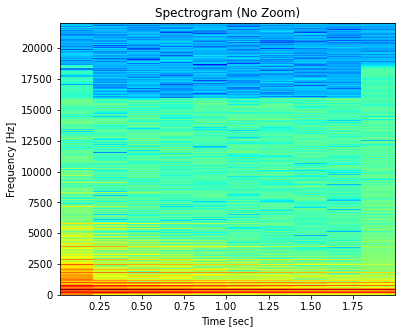

864
360
(360, 864, 4)
Audio_Files/Major/Major_13.wav


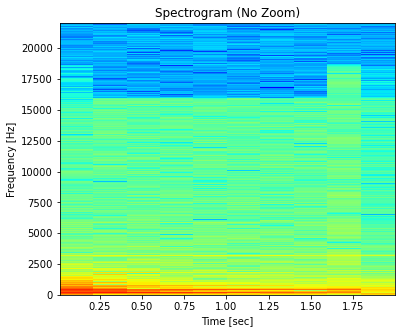

864
360
(360, 864, 4)
Audio_Files/Major/Major_14.wav


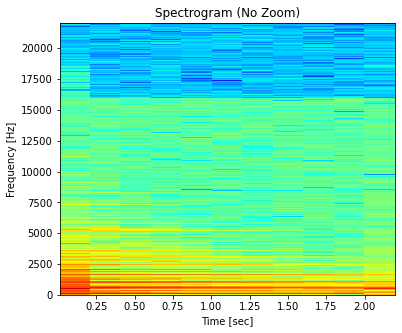

864
360
(360, 864, 4)
Audio_Files/Major/Major_15.wav


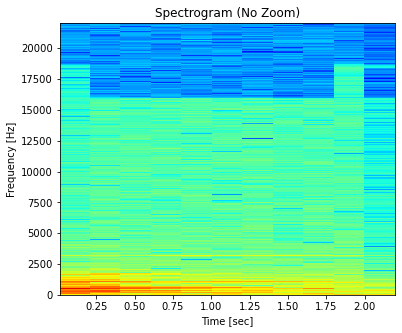

864
360
(360, 864, 4)
Audio_Files/Major/Major_16.wav


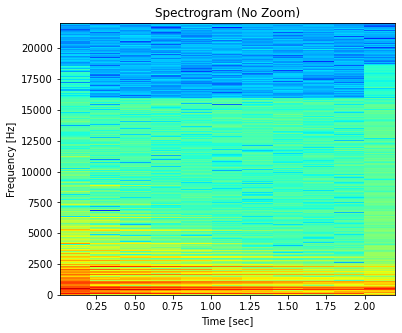

864
360
(360, 864, 4)
Audio_Files/Major/Major_17.wav


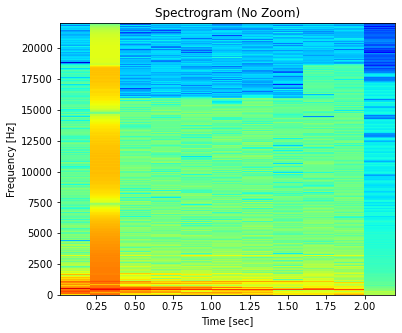

864
360
(360, 864, 4)
Audio_Files/Major/Major_18.wav


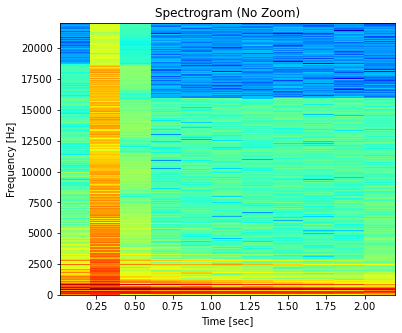

864
360
(360, 864, 4)
Audio_Files/Major/Major_19.wav


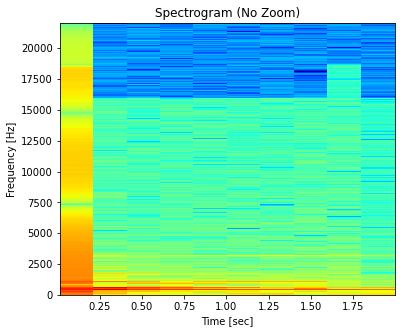

864
360
(360, 864, 4)
Audio_Files/Major/Major_20.wav


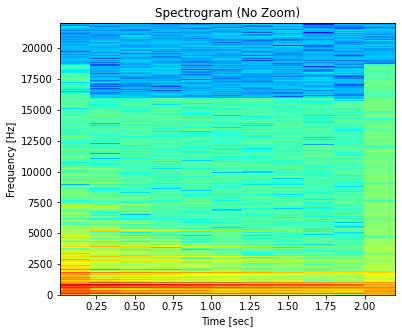

864
360
(360, 864, 4)
Audio_Files/Major/Major_21.wav


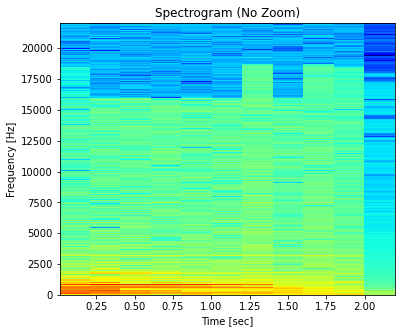

864
360
(360, 864, 4)
Audio_Files/Major/Major_22.wav


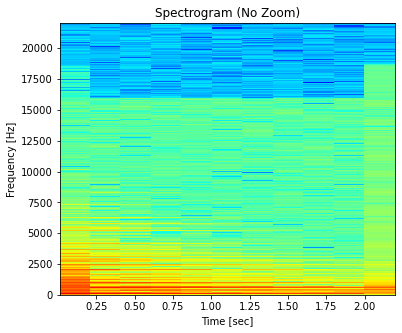

864
360
(360, 864, 4)
Audio_Files/Major/Major_23.wav


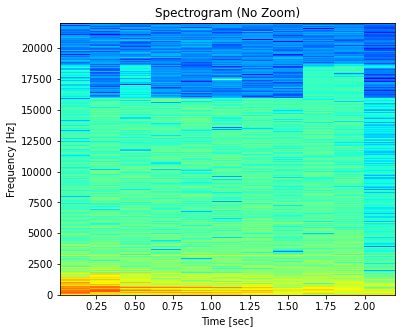

864
360
(360, 864, 4)
Audio_Files/Major/Major_24.wav


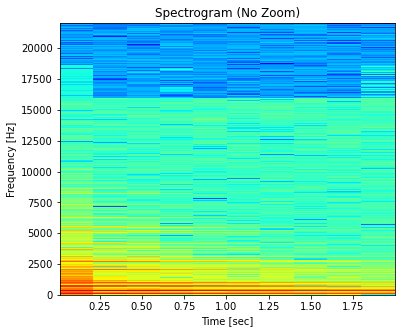

864
360
(360, 864, 4)
Audio_Files/Major/Major_25.wav


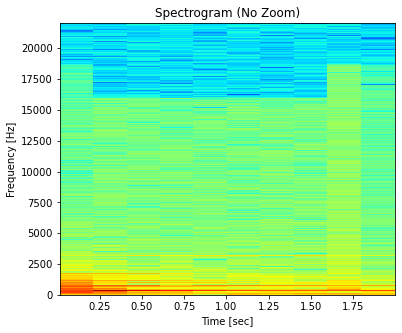

864
360
(360, 864, 4)
Audio_Files/Major/Major_26.wav


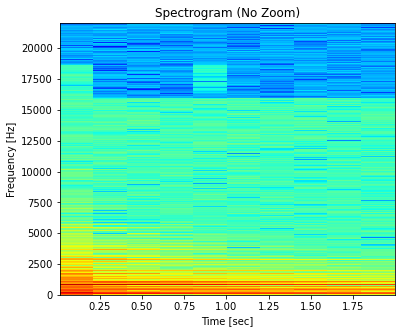

864
360
(360, 864, 4)
Audio_Files/Major/Major_27.wav


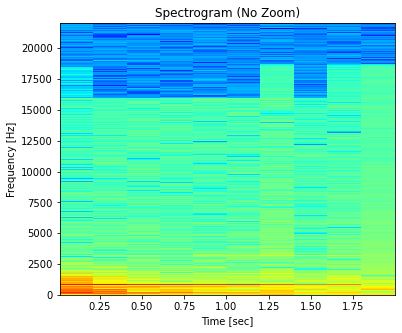

864
360
(360, 864, 4)
Audio_Files/Major/Major_28.wav


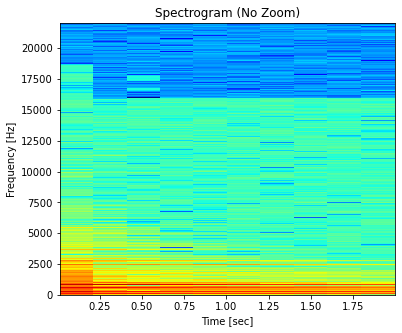

864
360
(360, 864, 4)
Audio_Files/Major/Major_29.wav


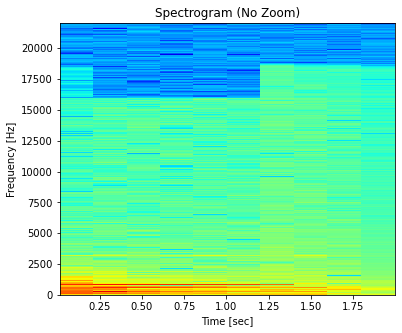

864
360
(360, 864, 4)
Audio_Files/Major/Major_30.wav


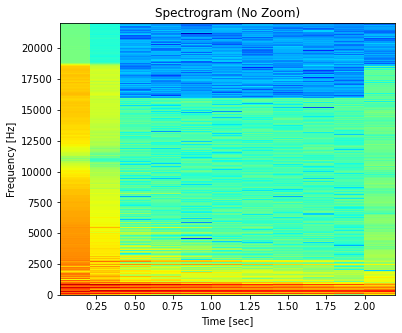

864
360
(360, 864, 4)
Audio_Files/Major/Major_31.wav


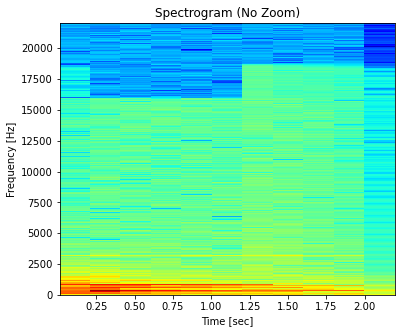

864
360
(360, 864, 4)
Audio_Files/Major/Major_32.wav


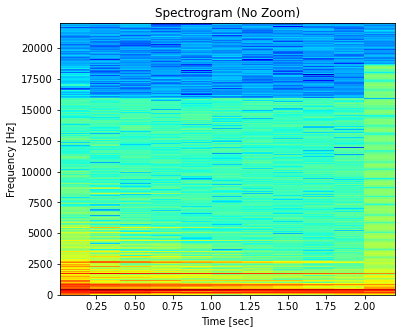

864
360
(360, 864, 4)
Audio_Files/Major/Major_33.wav


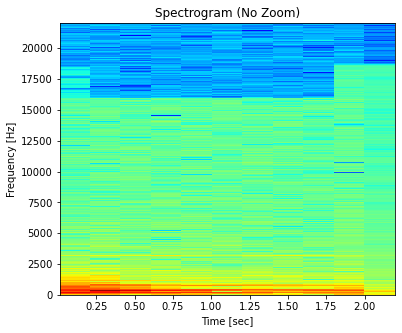

864
360
(360, 864, 4)
Audio_Files/Major/Major_34.wav


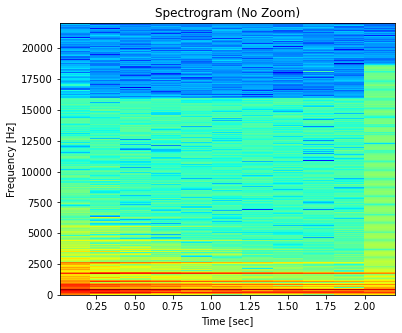

864
360
(360, 864, 4)
Audio_Files/Major/Major_35.wav


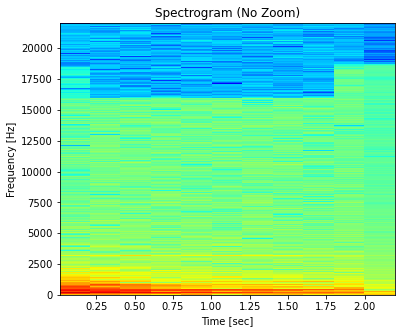

864
360
(360, 864, 4)
Audio_Files/Major/Major_36.wav


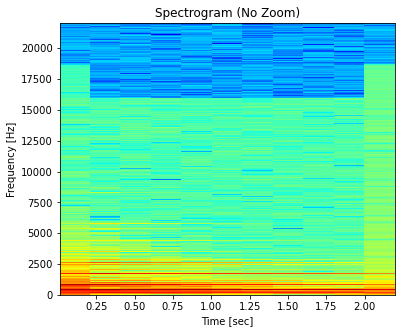

864
360
(360, 864, 4)
Audio_Files/Major/Major_37.wav


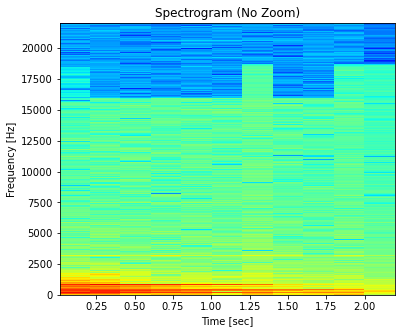

864
360
(360, 864, 4)
Audio_Files/Major/Major_38.wav


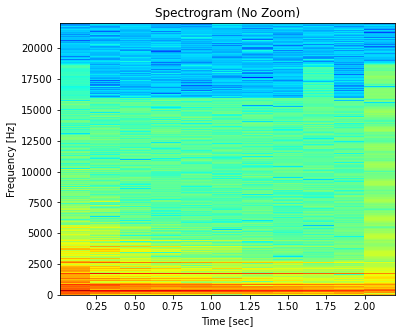

864
360
(360, 864, 4)
Audio_Files/Major/Major_39.wav


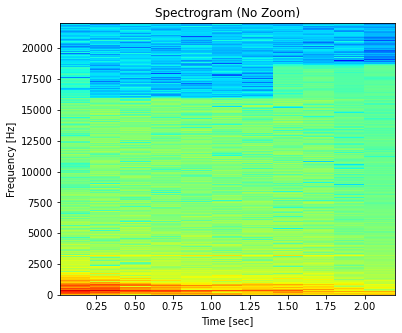

864
360
(360, 864, 4)
Audio_Files/Major/Major_40.wav


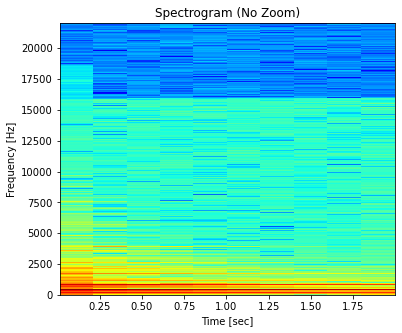

864
360
(360, 864, 4)
Audio_Files/Major/Major_41.wav


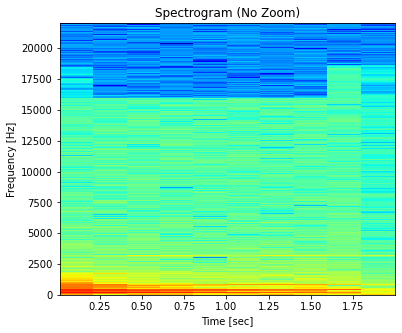

864
360
(360, 864, 4)
Audio_Files/Major/Major_42.wav


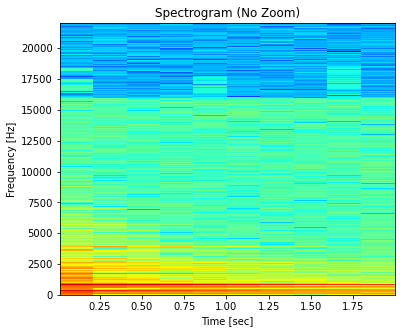

864
360
(360, 864, 4)
Audio_Files/Major/Major_43.wav


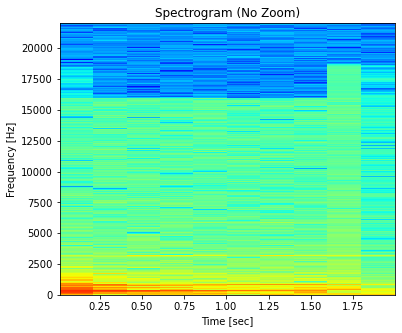

864
360
(360, 864, 4)
Audio_Files/Major/Major_44.wav


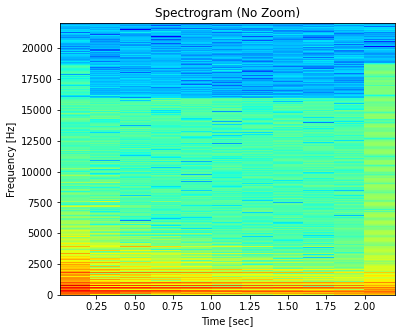

864
360
(360, 864, 4)
Audio_Files/Major/Major_45.wav


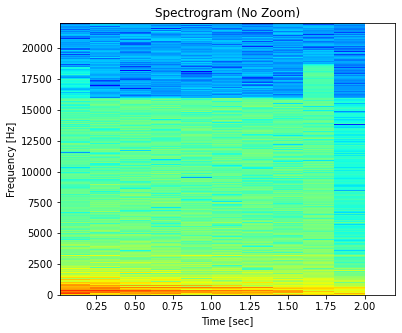

864
360
(360, 864, 4)
Audio_Files/Major/Major_46.wav


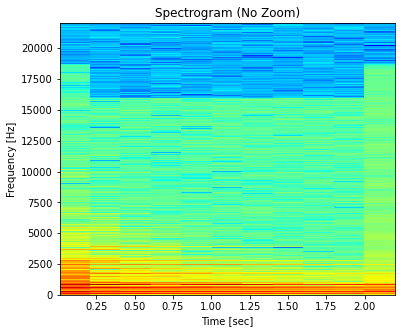

864
360
(360, 864, 4)
Audio_Files/Major/Major_47.wav


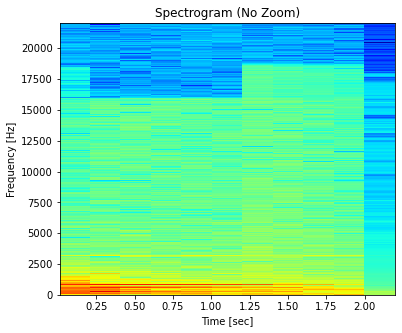

864
360
(360, 864, 4)
Audio_Files/Major/Major_48.wav


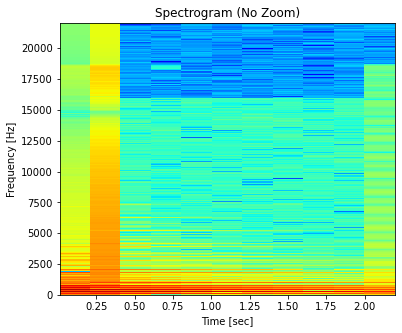

864
360
(360, 864, 4)
Audio_Files/Major/Major_49.wav


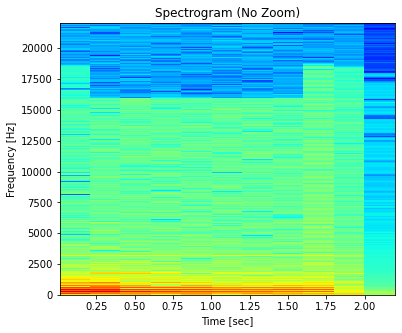

864
360
(360, 864, 4)
Audio_Files/Major/Major_50.wav


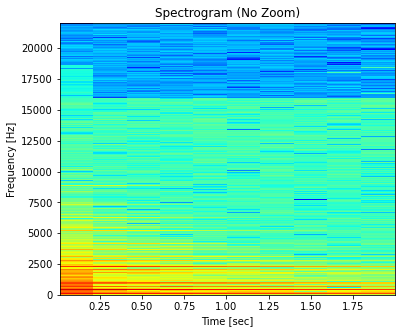

864
360
(360, 864, 4)
Audio_Files/Major/Major_51.wav


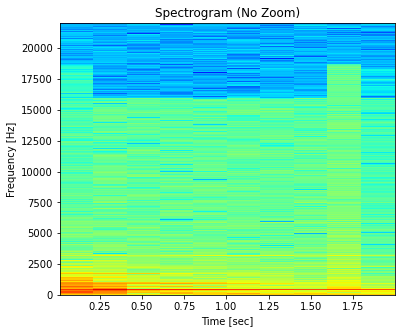

864
360
(360, 864, 4)
Audio_Files/Major/Major_52.wav


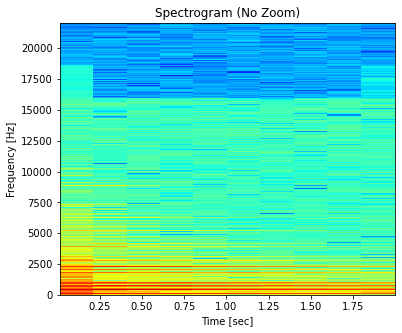

864
360
(360, 864, 4)
Audio_Files/Major/Major_53.wav


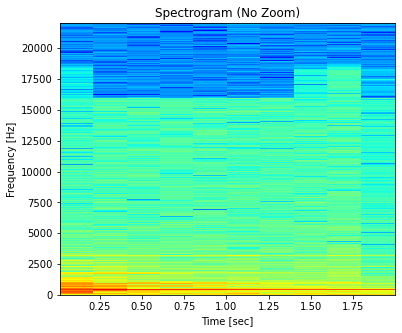

864
360
(360, 864, 4)
Audio_Files/Major/Major_54.wav


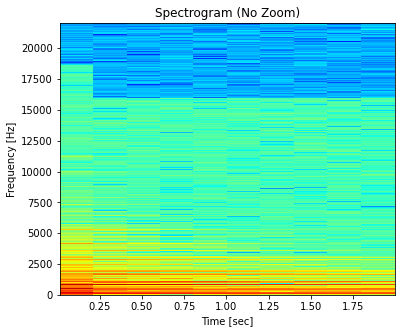

864
360
(360, 864, 4)
Audio_Files/Major/Major_55.wav


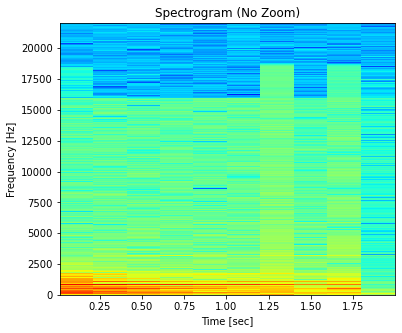

864
360
(360, 864, 4)
Audio_Files/Major/Major_56.wav


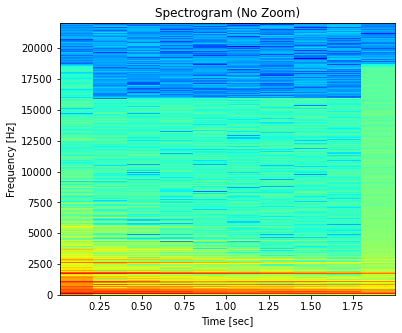

864
360
(360, 864, 4)
Audio_Files/Major/Major_57.wav


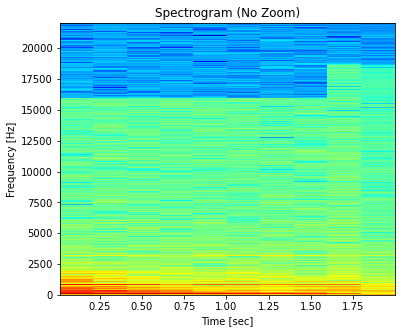

864
360
(360, 864, 4)
Audio_Files/Major/Major_58.wav


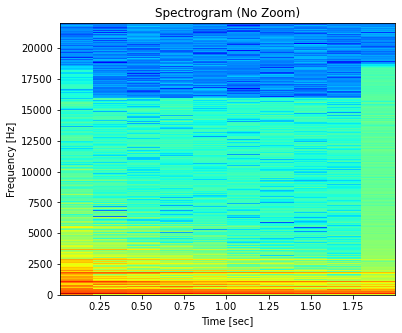

864
360
(360, 864, 4)
Audio_Files/Major/Major_59.wav


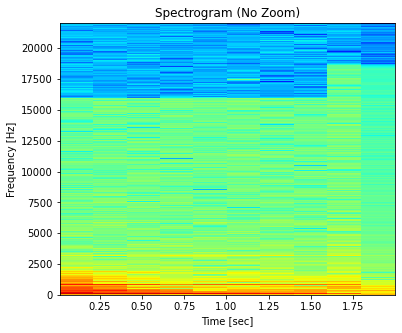

864
360
(360, 864, 4)
Audio_Files/Major/Major_60.wav


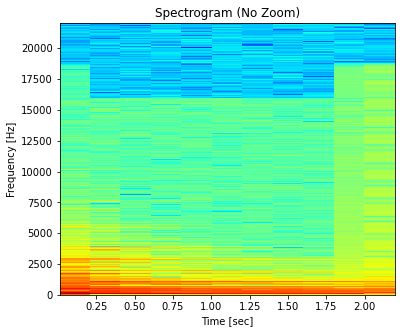

864
360
(360, 864, 4)
Audio_Files/Major/Major_61.wav


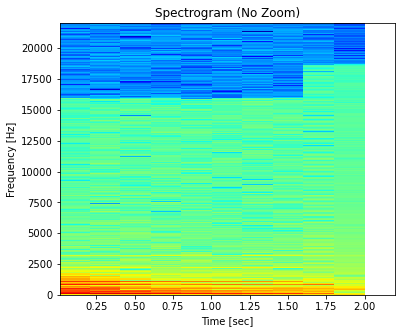

864
360
(360, 864, 4)
Audio_Files/Major/Major_62.wav


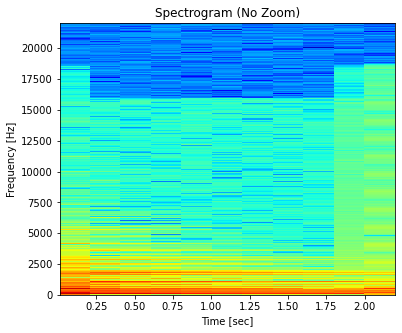

864
360
(360, 864, 4)
Audio_Files/Major/Major_63.wav


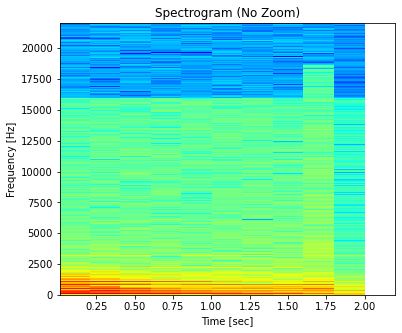

864
360
(360, 864, 4)
Audio_Files/Major/Major_64.wav


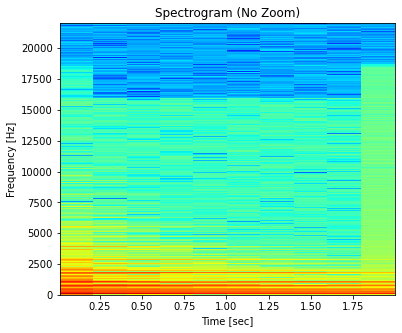

864
360
(360, 864, 4)
Audio_Files/Major/Major_65.wav


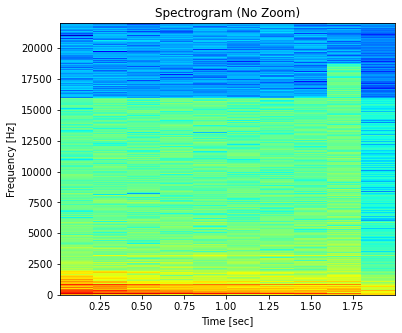

864
360
(360, 864, 4)
Audio_Files/Major/Major_66.wav


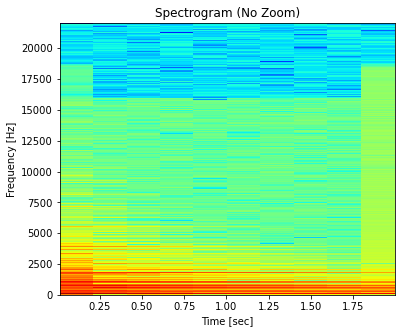

864
360
(360, 864, 4)
Audio_Files/Major/Major_67.wav


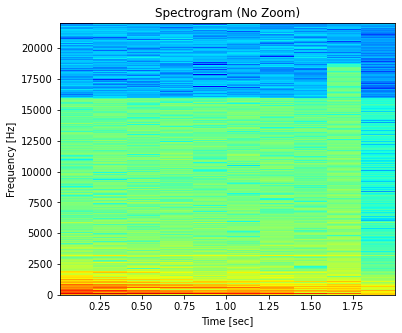

864
360
(360, 864, 4)
Audio_Files/Major/Major_68.wav


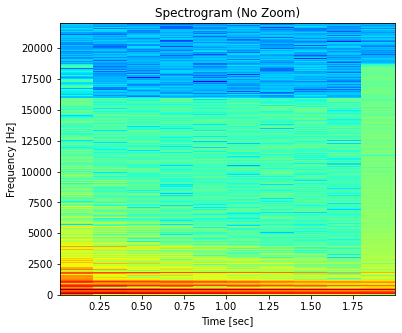

864
360
(360, 864, 4)
Audio_Files/Major/Major_69.wav


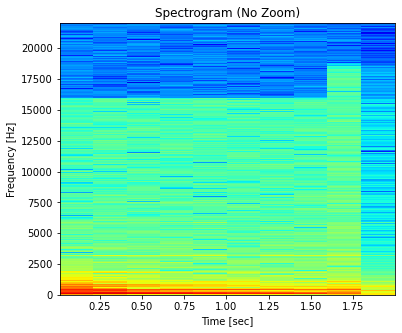

864
360
(360, 864, 4)
Audio_Files/Major/Major_70.wav


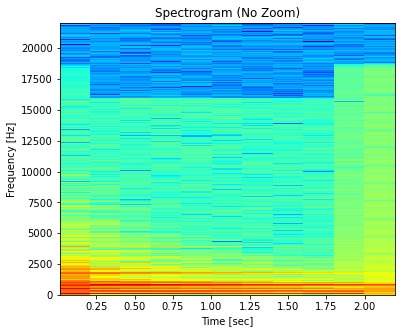

864
360
(360, 864, 4)
Audio_Files/Major/Major_71.wav


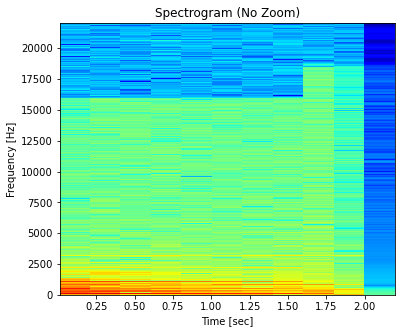

864
360
(360, 864, 4)
Audio_Files/Major/Major_72.wav


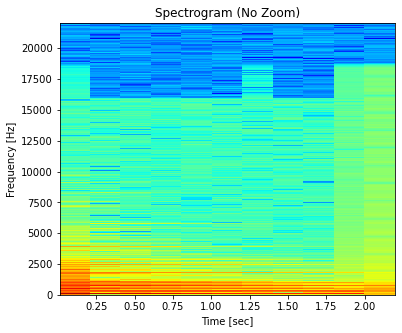

864
360
(360, 864, 4)
Audio_Files/Major/Major_73.wav


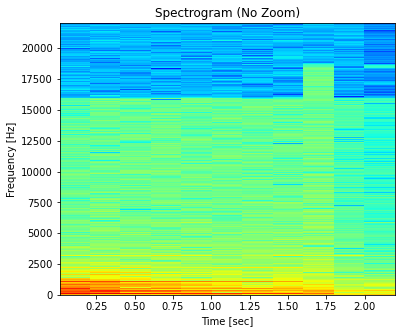

864
360
(360, 864, 4)
Audio_Files/Major/Major_74.wav


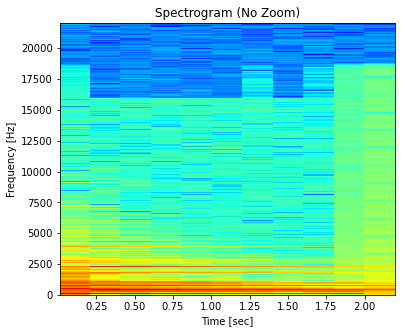

864
360
(360, 864, 4)
Audio_Files/Major/Major_75.wav


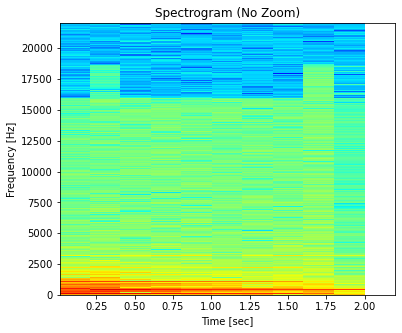

864
360
(360, 864, 4)
Audio_Files/Major/Major_76.wav


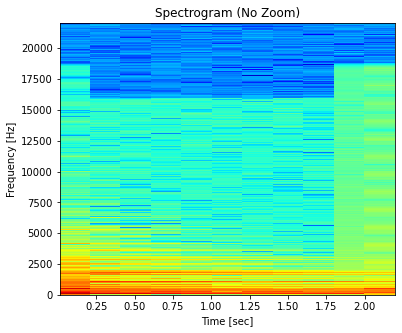

864
360
(360, 864, 4)
Audio_Files/Major/Major_77.wav


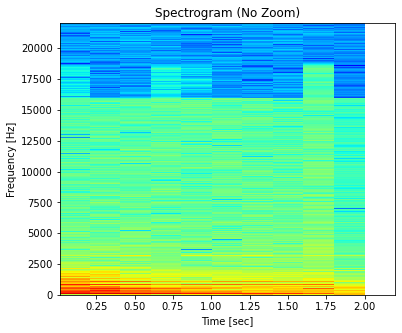

864
360
(360, 864, 4)
Audio_Files/Major/Major_78.wav


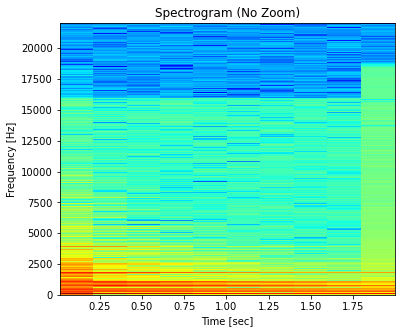

864
360
(360, 864, 4)
Audio_Files/Major/Major_79.wav


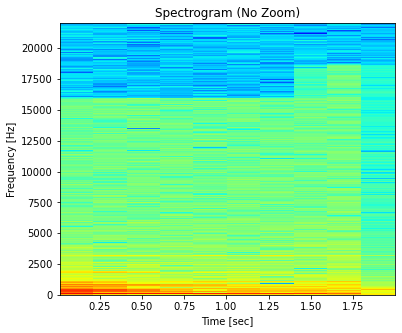

864
360
(360, 864, 4)
Audio_Files/Major/Major_80.wav


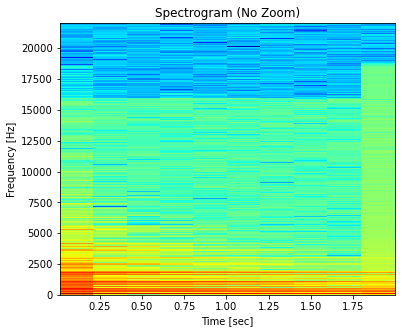

864
360
(360, 864, 4)
Audio_Files/Major/Major_81.wav


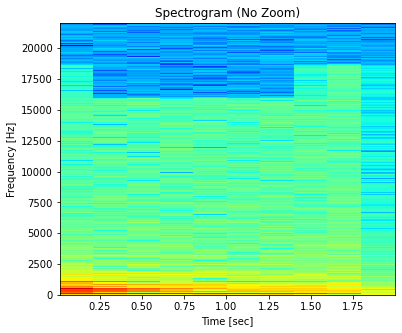

864
360
(360, 864, 4)
Audio_Files/Major/Major_82.wav


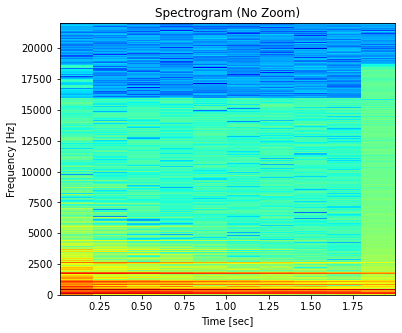

864
360
(360, 864, 4)
Audio_Files/Major/Major_83.wav


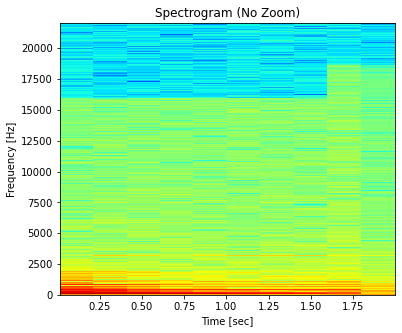

864
360
(360, 864, 4)
Audio_Files/Major/Major_84.wav


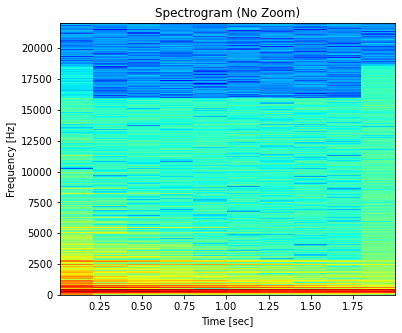

864
360
(360, 864, 4)
Audio_Files/Major/Major_85.wav


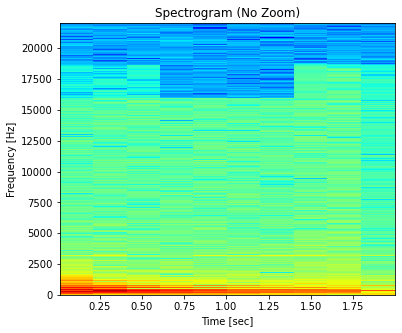

864
360
(360, 864, 4)
Audio_Files/Major/Major_86.wav


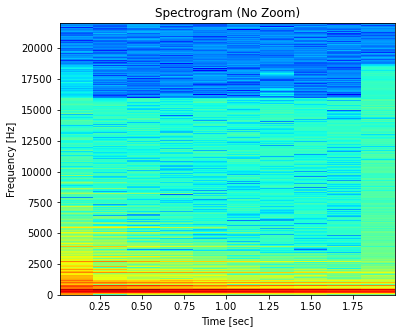

864
360
(360, 864, 4)
Audio_Files/Major/Major_87.wav


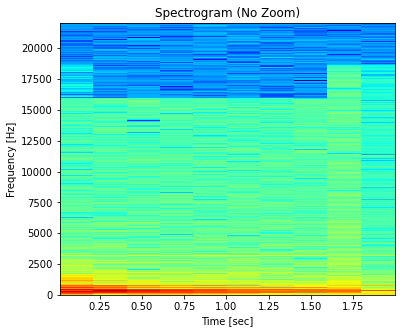

864
360
(360, 864, 4)
Audio_Files/Major/Major_88.wav


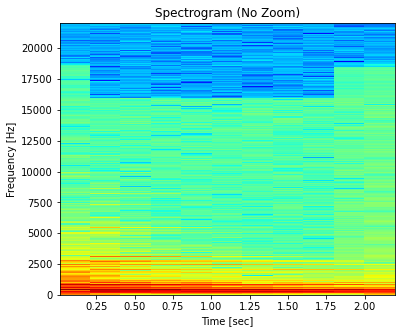

864
360
(360, 864, 4)
Audio_Files/Major/Major_89.wav


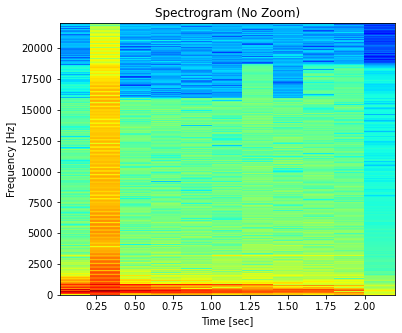

864
360
(360, 864, 4)
Audio_Files/Major/Major_90.wav


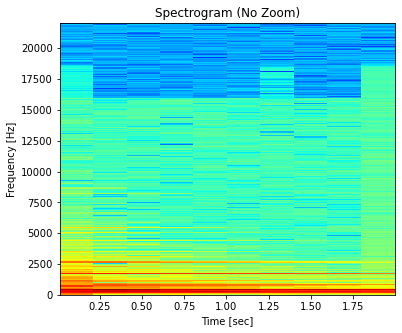

864
360
(360, 864, 4)
Audio_Files/Major/Major_91.wav


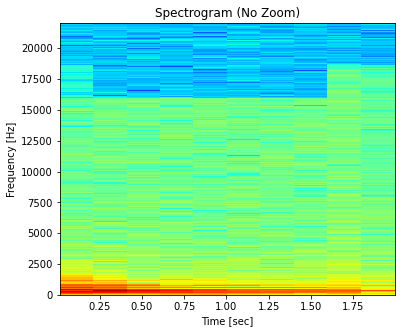

864
360
(360, 864, 4)
Audio_Files/Major/Major_92.wav


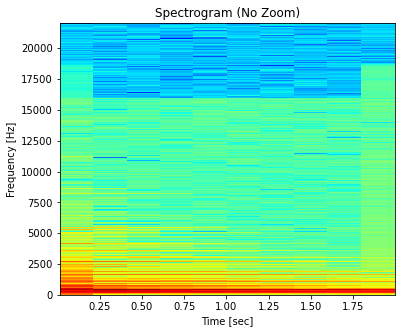

864
360
(360, 864, 4)
Audio_Files/Major/Major_93.wav


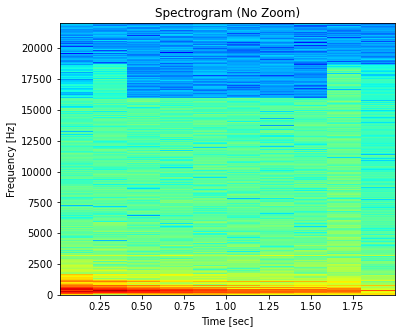

864
360
(360, 864, 4)
Audio_Files/Major/Major_94.wav


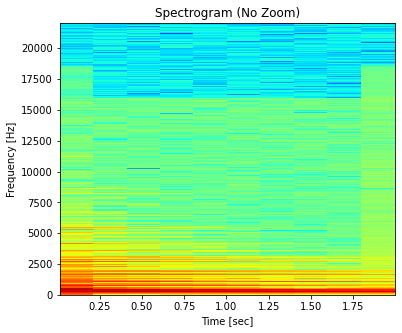

864
360
(360, 864, 4)
Audio_Files/Major/Major_95.wav


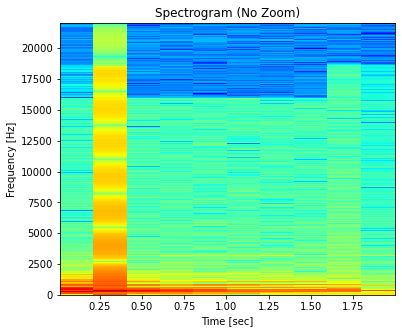

864
360
(360, 864, 4)
Audio_Files/Major/Major_96.wav


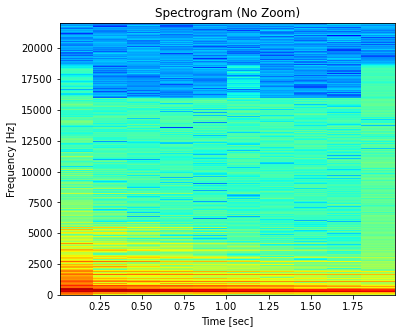

864
360
(360, 864, 4)
Audio_Files/Major/Major_97.wav


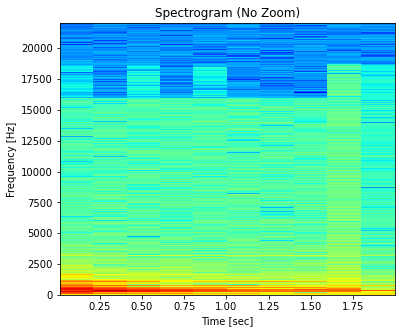

864
360
(360, 864, 4)
Audio_Files/Major/Major_98.wav


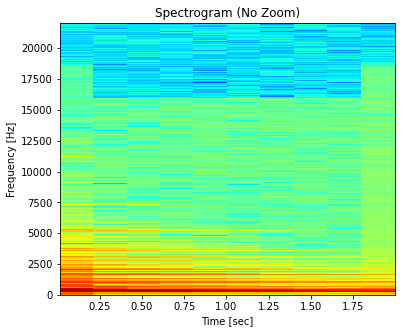

864
360
(360, 864, 4)
Audio_Files/Major/Major_99.wav


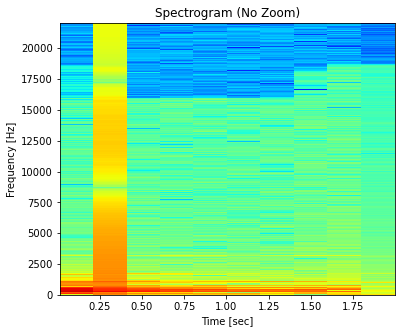

864
360
(360, 864, 4)
Audio_Files/Major/Major_100.wav


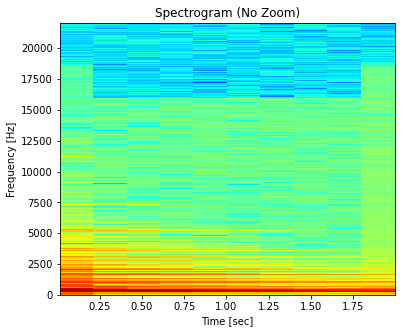

864
360
(360, 864, 4)
Audio_Files/Major/Major_101.wav


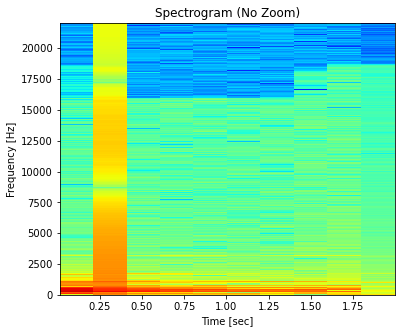

864
360
(360, 864, 4)


ValueError: Found input variables with inconsistent numbers of samples: [102, 859]

In [121]:
# Data preoprocessing

N = 502 # number of images
X_train = np.zeros((N, 360, 864, 4))
for i in range(0, N):
    print('Audio_Files/Major/Major_'+str(i)+'.wav')
    fs, signal = wavfile.read('Audio_Files/Major/Major_'+str(i)+'.wav') # get a frequency sample and signal from a wavfile
    f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft=50000)
    feature = generateNoZoomSpectrogram(f, t, Sxx)

    # get the current image and convert to feature, as above

    X_train[i] = np.copy(feature)
    
n = 357 # number of images
for k in range(0, n):
    print('Audio_Files/Minor/Minor_'+str(k)+'.wav')
    fs, signal = wavfile.read('Audio_Files/Minor/Minor_'+str(k)+'.wav') # get a frequency sample and signal from a wavfile
    f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft=50000)
    feature = generateNoZoomSpectrogram(f, t, Sxx)

    # get the current image and convert to feature, as above

    X_train[i] = np.copy(feature)
    
train_X, val_X, train_y, val_y = train_test_split(X_train, df["Chord Type"], test_size=0.40, random_state=0)

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [122]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(360, 864, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 862, 32)      1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 431, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 429, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 214, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 212, 64)       36928     
Total params: 56,608
Trainable params: 56,608
Non-trainable params: 0
_________________________________________________________________


### Add Dense layers on top

In [124]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [125]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 862, 32)      1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 431, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 429, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 214, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 212, 64)       36928     
_________________________________________________________________
flatten (Flatten)            (None, 1166848)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

In [126]:

# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=10, 
                    validation_data=(val_X, val_y))

Epoch 1/10


ValueError: in user code:

    D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 7]
